In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

In [2]:
# loop through all files in the directory, save it in a list and print heads
files = []
for i in range(1, 5):
    files_in_folder = os.listdir(f"data/Actividades de Seguimiento/Actividad de Seguimiento {i}")
    for file in files_in_folder:
        if file.endswith(".xlsx"):
            files.append(f"data/Actividades de Seguimiento/Actividad de Seguimiento {i}/{file}")


In [3]:
df = pd.read_excel(files[0])
print(files[0])
print(df.info())

data/Actividades de Seguimiento/Actividad de Seguimiento 1/2025-1 (M10) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 1-calificaciones.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Apellido(s)          113 non-null    object 
 1   Nombre               112 non-null    object 
 2   Número de ID         112 non-null    float64
 3   Dirección de correo  112 non-null    object 
 4   Departamento         2 non-null      object 
 5   Institución          11 non-null     object 
 6   Estado               112 non-null    object 
 7   Comenzado el         112 non-null    object 
 8   Finalizado           112 non-null    object 
 9   Tiempo requerido     112 non-null    object 
 10  Calificación/10,00   113 non-null    object 
 11  P. 1 /0,75           113 non-null    object 
 12  P. 2 /0,75          

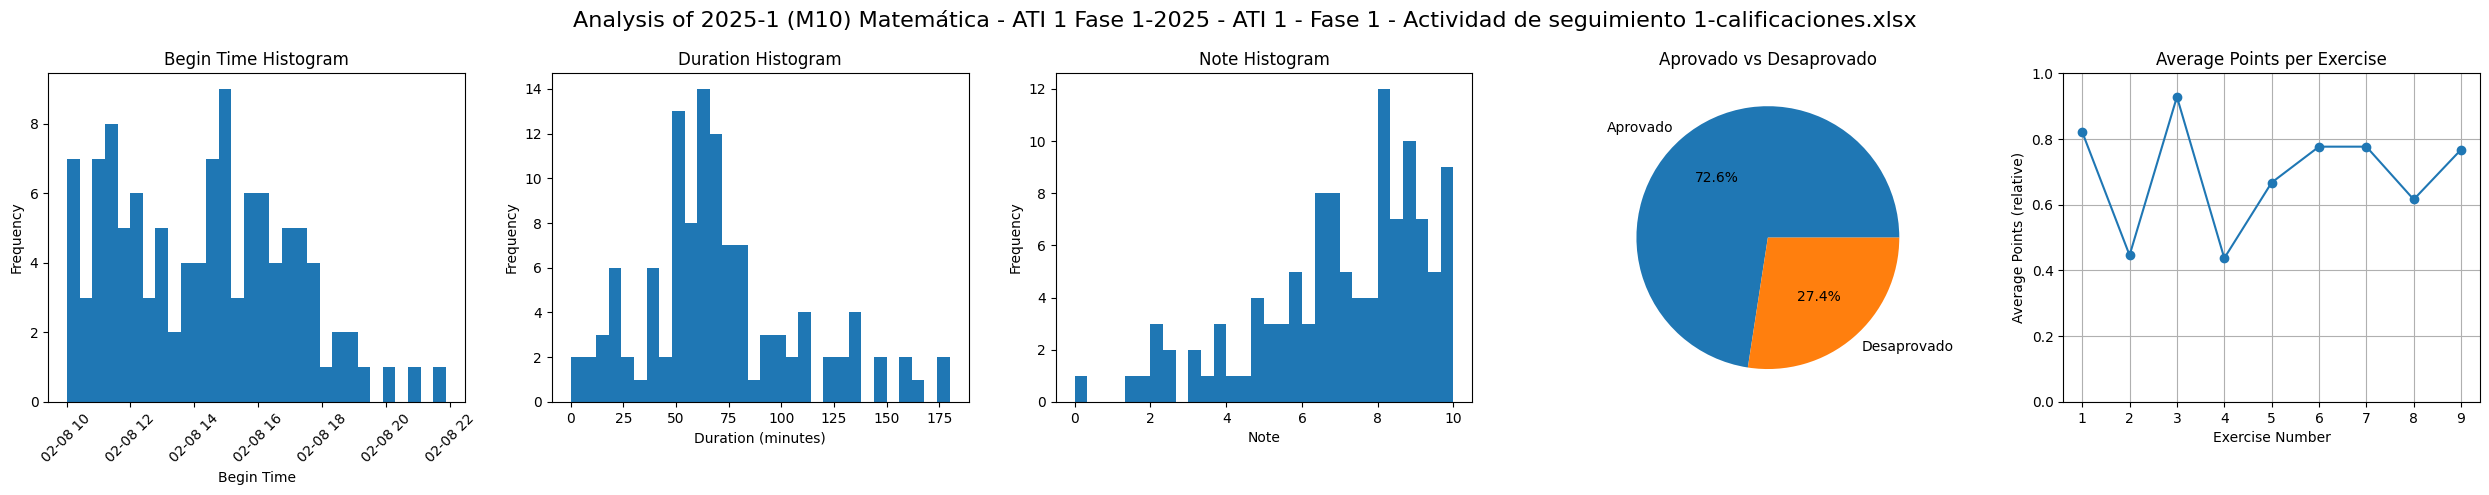

In [4]:
month_mapping = {
        "enero": 1, "febrero": 2, "marzo": 3, "abril": 4,
        "mayo": 5, "junio": 6, "julio": 7, "agosto": 8,
        "septiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12
    }

def plot_begin_time(df, ax):
    def create_timestamp(row):
        time_str = str(row['Comenzado el']).strip()
        try:
            parts = time_str.split(" de ")
            day = int(parts[0])
            month = month_mapping[parts[1].lower()]
            year = int(parts[2].split()[0])
            minute = int(time_str[-2:])
            hour = int(time_str[-5:-3])
            return pd.to_datetime(f"{year}-{month}-{day} {hour}:{minute}", format="%Y-%m-%d %H:%M")
        except (ValueError, IndexError):
            return pd.NaT
    df['begin_time'] = df.apply(create_timestamp, axis=1)
    ax.hist(df['begin_time'], bins=30)
    ax.set_xlabel("Begin Time")
    ax.set_ylabel("Frequency")
    ax.set_title("Begin Time Histogram")
    ax.tick_params(axis='x', rotation=45)

def plot_duration(df, ax):
    def parse_duration(row):
        duration_str = str(row['Tiempo requerido']).strip()
        total_minutes = 0
        if "hora" in duration_str:
            hours = int(duration_str.split("hora")[0].strip())
            total_minutes += hours * 60
        if "minuto" in duration_str:
            minutes_part = duration_str.split("minuto")[0]
            minutes = int(minutes_part.split()[-1].strip())
            total_minutes += minutes
        if "segundo" in duration_str:
            seconds_part = duration_str.split("segundo")[0]
            seconds = int(seconds_part.split()[-1].strip())
            total_minutes += seconds / 60
        return total_minutes
    df["duration"] = df.apply(parse_duration, axis=1)
    ax.hist(df["duration"], bins=30)
    ax.set_xlabel("Duration (minutes)")
    ax.set_ylabel("Frequency")
    ax.set_title("Duration Histogram")

def plot_notes(df, ax1, ax2):
    df["note"] = df["Calificación/10,00"].apply(lambda x: float(str(x).replace(",", ".")))
    ax1.hist(df["note"], bins=30)
    ax1.set_xlabel("Note")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Note Histogram")
    # pie plot of aprovoda and not (if note >= 6)
    df["aprovado"] = df["note"].apply(lambda x: "Aprovado" if x >= 6 else "Desaprovado")
    ax2.pie(df["aprovado"].value_counts(), labels=df["aprovado"].value_counts().index, autopct='%1.1f%%')
    ax2.set_title("Aprovado vs Desaprovado")
    ax2.set_ylabel("")

def plot_ejercicios(df, ax):
    print_exact_data = False
    pattern = r"^P\. \d+ .*$"
    exercise = 1
    average_points = []
    for column in df.columns:
        if bool(re.match(pattern, column)):
            df.loc[df[column] == "-", column] = 0
            df[column] = df[column].apply(lambda x: float(str(x).replace(",", ".")))
            match = re.search(r"[-+]?\d+,\d+$", column)
            max_points = float(match.group().replace(",", "."))
            average_points.append(df[column].mean() / max_points)
            if print_exact_data:
                print(f"Exercise {exercise}:")
                print(f"Average: {round(df[column].mean(), 2)} out of {max_points} | relative: {round(df[column].mean() / max_points * 100, 2)}%")
                print(f"Share of correct answers: {sum(df[column] == max_points) / len(df[column]) * 100:.2f}%")
                print(f"----------------------")
            exercise += 1
    ax.plot(range(1, len(average_points) + 1), average_points, marker='o')
    ax.set_xticks(range(1, len(average_points) + 1))
    ax.set_xlabel("Exercise Number")
    ax.set_ylabel("Average Points (relative)")
    ax.set_title("Average Points per Exercise")
    ax.set_ylim(0, 1)
    ax.grid()


def analyse_file(file):
    df = pd.read_excel(file)
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    # get name of file without path after last /
    fig.suptitle(f"Analysis of {file.split("/")[-1]}", fontsize=16)
    axes = axes.flatten()
    plot_begin_time(df, axes[0])
    plot_duration(df, axes[1])
    plot_notes(df, axes[2], axes[3])
    plot_ejercicios(df, axes[4])
    plt.tight_layout()
    plt.show()
    


analyse_file(files[0])

In [5]:
# for file in files:
#     analyse_file(file)

File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 1-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File ATI 1 Fase 1 - Matemática - Tres Arroyos-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 2 - Cursos M-calificaciones.xlsx does not contain a commission number.
File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 2 - Cursos M-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File 2025-1 (M1) Matemática - ATI 1 Fase 1-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 3 - Cursos M-calificaciones.xlsx contains non-numeric, non-nan DNI value a4014736.
File ATI 1 Fase 1 - Matemática - Tres Arroyos-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 3 - Cursos M-calificaciones.xlsx does not contain a commission number.
File ATI 1 Fase 1 - Matemática - Tres Arroyos-2025 - ATI 1 - Fase 1 - Actividad de seguimiento 4 - Cursos M-calificaciones.xlsx does not contain a c

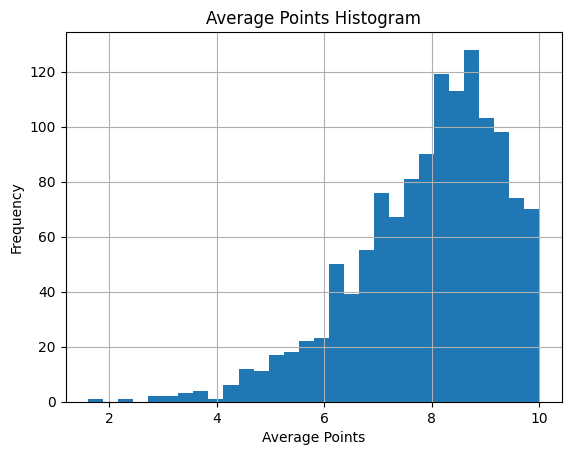

In [ ]:
df_ati_anonimo = pd.read_excel('data/Ati_anonimo.xlsx')
#print(df_ati_anonimo.info())

df = pd.DataFrame(columns=["DNI", "COMISION", "SEGUIMIENTO 1", "SEGUIMIENTO 2", "SEGUIMIENTO 3", "SEGUIMIENTO 4", "NOTA DE ANONIMO"])

df["DNI"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["DNI"].values
df["DNI"] = df["DNI"].apply(lambda x: int(str(x).replace(".", "").replace(" ", "")))
df["COMISION"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["COMISION"].values
df["NOTA DE ANONIMO"] = df_ati_anonimo.drop_duplicates(subset=['DNI', 'COMISION', 'NOTA'], keep=False)["NOTA"].values

number_of_people_not_in_anonimo = 0

for seguimiento in range(1, 5):
    files_in_folder = os.listdir(f"data/Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}")
    for file in files_in_folder:
        if file.endswith(".xlsx"):
            df_file = pd.read_excel(f"data/Actividades de Seguimiento/Actividad de Seguimiento {seguimiento}/{file}")
            match = re.search(r'\((.*?)\)', file)
            if match:
                comision = match.group(1)
                for index, row in df_file.iterrows():
                    dni = row["Número de ID"]
                    points = float(str(row["Calificación/10,00"]).replace(",", "."))
                    if re.search(r'[a-zA-Z]', str(dni)):
                        # check if nan
                        if not pd.isna(dni):
                            print(f"File {file} contains non-numeric, non-nan DNI value {dni}.")
                    else:
                        dni = int(dni)
                        if df[(df["DNI"] == dni) & (df["COMISION"] == comision)].empty:
                            number_of_people_not_in_anonimo += 1
                            # print(f"File {file} contains a dni {dni} with commission {comision} that is not in the anonimo file.")
                            #! If the dni is not in the anonimo file, add it to the df
                            df = pd.concat([df, pd.DataFrame([{"DNI": dni, "COMISION": comision, f"SEGUIMIENTO {seguimiento}": points}])], ignore_index=True)
                        else:
                            df.loc[(df["DNI"] == dni) & (df["COMISION"] == comision), f"SEGUIMIENTO {seguimiento}"] = points
            else:
                print(f"File {file} does not contain a commission number.")

df["Number of Approved"] = df.apply(lambda x: sum(x[f"SEGUIMIENTO {i}"] >= 6 for i in range(1, 5)), axis=1)
df["Total Points"] = df.apply(lambda x: sum(x[f"SEGUIMIENTO {i}"] for i in range(1, 5)), axis=1)
df["Average Points"] = df.apply(lambda x: sum(x[f"SEGUIMIENTO {i}"] for i in range(1, 5)) / 4, axis=1)

print(f"Number of people not in anonimo file: {number_of_people_not_in_anonimo}")
df.to_excel("data/03_cursos_output.xlsx", index=False)

# plot hist of average points
df["Average Points"].hist(bins=30)
plt.xlabel("Average Points")
plt.ylabel("Frequency")
plt.title("Average Points Histogram")
plt.show()



#TODO Discuss: There are many people without anonimo entry, should we still use the nota in there?

#TODO DIESES HISTOGRAM HIER SOLL EIN STACKED BARCHART SEIN, MIT PUNKTEN AUS DEN SEGUIMIENTOS PRO FARBE

In [7]:
# show dataframe info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DNI                 4174 non-null   int64  
 1   COMISION            4174 non-null   object 
 2   SEGUIMIENTO 1       2700 non-null   object 
 3   SEGUIMIENTO 2       2611 non-null   object 
 4   SEGUIMIENTO 3       2386 non-null   object 
 5   SEGUIMIENTO 4       1409 non-null   object 
 6   Number of Approved  4174 non-null   int64  
 7   Total Points        1286 non-null   float64
 8   Average Points      1286 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 293.6+ KB
None


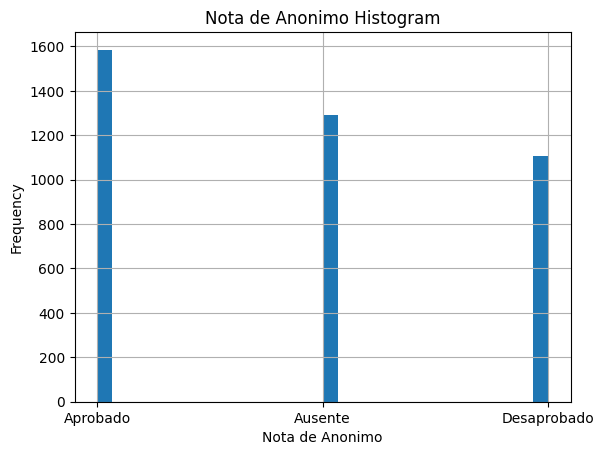

In [9]:
# histogram of nota de anonimo
df["NOTA DE ANONIMO"].hist(bins=30)
plt.xlabel("Nota de Anonimo")
plt.ylabel("Frequency")
plt.title("Nota de Anonimo Histogram")
plt.show()

In [10]:
df.to_excel("data/03_cursos_output.xlsx", index=False)